### Calculating many excited states of the multidimensional time-independent Schrödinger equation using a neural network

This notebook reproduces the paper by Jinde Liu *et. al*, where they used a PINN to compute the multiple excited states of a Time-Independent Schrodinger Equation (TISE) using a neural network. They also computed the solution in high dimension. What is really interesting about this work is the accurate results with small number of epochs, and this does not increase due to higher dimensions The paper can be found here https://doi.org/10.1103/PhysRevA.108.032803

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim     #optimizer  
import time
import copy
import torch.nn.functional as F

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

#if device.type == 'cuda':
#  print(torch.cuda.get_device_name(0))

cuda


In [ ]:
### Loss Functions 
#The algorithm contains 4 loss functions 
#1) variance of energy: Addresses convergence imbalance

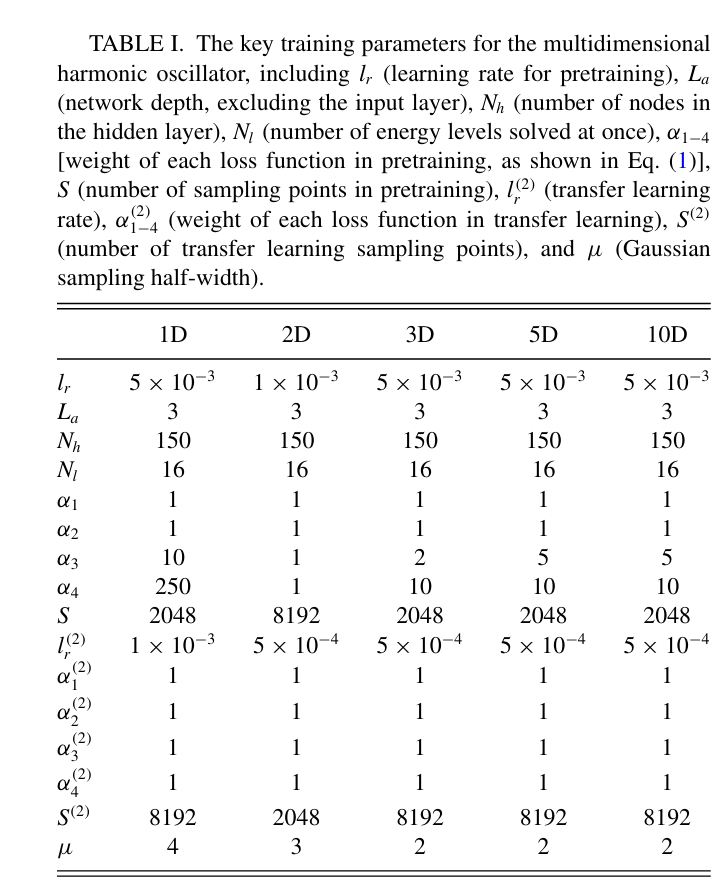

In [126]:
#Defining the hyperparameters
class config:
  def __init__(self):
    self.t0 = -10
    self.tf = 10
    self.xbc = 0
    self.num_epoch = 10000

    #Parameters for sampling
    self.D = 1 #Spatial dimension
    self.mu = 4.0 
    self.batch1 = 2048 #Batch for pretrainer
    self.batch2 = 8192 #Batch after transfer learning

    #Model parameters
    self.eig_num = 16
    self.layers = [self.D,150,150,150,self.eig_num] #Number of layer
    self.alphas1 = [1,1,10,250] #Alphas for pretrainer
    self.alphas2 = torch.ones(4) #alpha for transfer learning

    #Optimizer
    self.lr1 = 5e-3 #Batch for pretrainer
    self.lr2 = 1e-3 #Batch after transfer learning

cfg = config()

In [127]:
def laplacian(f,x):
  laplace = []
  for i in range(f.shape[1]):
    u_x = grad(f[:,i], x, grad_outputs=torch.ones_like(f[:,i]), create_graph=True,retain_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    laplace.append(u_xx.sum(dim=1, keepdim=True)) #Sum the 2nd derivatives across the dimensions
  laplace = torch.cat(laplace, dim=1)
  return laplace

In [128]:
#Generating collocation points
def col_pts_func(batch,Dim,mu):
    sigma = mu / np.sqrt(2) #standard deviation for sampling
    x_col= (torch.randn(batch, Dim, device= device) * sigma).float()

    #The density function
    P_X = torch.exp(-torch.sum(x_col**2, dim=1, keepdim=True) / mu**2)

    #Weights for Monte-Carlo integration
    weights = 1.0 / P_X

    return x_col, weights

In [129]:
#Computing the harmonic potential
def pot(t):
    return 0.5 * (t.pow(2).sum(dim=1, keepdim=True))

In [135]:
#Defining the losses
class losses:
    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

    def forward(self, x):
        return self.model(x)
    
    def orthogonality(self, f, whts):
        #f: (batch, eig_num)
        psi_weighted = f * torch.sqrt(whts) #(batch, eig_num)

        #The Gram matrix:  G = ψᵀ W ψ
        G_m = psi_weighted.T @ psi_weighted/ f.shape[0] #(eig_num, eig_num)

        identity = torch.eye(self.cfg.eig_num, device = f.device)

        ortho_loss = (G_m-identity).pow(2).sum()

        return ortho_loss


    def loss_total(self, x, v, whts, alphas):
        g = x.clone().requires_grad_(True)
        psi = self.model(g) #(batch, eig_num)
        psi_xx = laplacian(psi,g) #(batch, eig_num)
        H_psi = -0.5 * psi_xx + v*psi #(batch, eig_num)

        #The Variance of energy loss
        H2 = (whts * H_psi.pow(2)).mean(dim=0, keepdim=True) #(1,eig_num)
        E = (whts * psi * H_psi).mean(dim=0, keepdim=True)  #(1,eig_num), the average energy or eigenvalue

        VoE_loss = H2 - E**2 #Loss for variance of energy

        #The residual loss
        res_loss = (whts * (H_psi - E*psi)**2).mean(dim=0, keepdim=True) #(1,eig_num)

        #The normalization loss
        norm_loss = ((whts* psi.pow(2)).mean(dim=0, keepdim=True) - 1).pow(2) #(1,eig_num)

        #The orthogonality loss
        ortho_loss = self.orthogonality(psi,whts)

        total_loss = alphas[0]* VoE_loss.sum() + alphas[1]* res_loss.sum() + alphas[2]* norm_loss.sum() + alphas[3] * ortho_loss

        t_losses = {
            'VoE_loss': VoE_loss,
            'res_loss': res_loss,
            'norm_loss': norm_loss,
            'ortho_loss': ortho_loss,
            'total_loss': total_loss
        }
        return t_losses, E


In [136]:
#Defining the neural network architecture
class NN(torch.nn.Module):
    def __init__(self, cfg):
        super(NN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = cfg.layers
        self.eig_num = cfg.eig_num
        self.Dim = cfg.D 

        #The linear layers
        self.linears = nn.ModuleList(
            [nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)]
        )
        #Trainable parameters to enforce boundary
        self.nu = nn.Parameter(torch.rand(self.eig_num, self.Dim)) #(eig_num, Dim)

        #Initializing the weights
        for i in range(len(self.layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            #nn.init.xavier_normal_(self.linears[i].bias.data, gain = 1.0)

    #The forward pass
    def forward(self,x):
        a = x
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        #The boundary enforcing term
        x_sq = x.unsqueeze(1) ** 2 #(batch, 1, Dim)
        exponent = -0.5 * torch.sum(self.nu * x_sq, dim = -1) #Sum over the dimensions
        B = torch.exp(exponent) #(batch, eig_num)
        psi = a * B #(batch, eig_num)

        return psi

#### Training

In [132]:
model = NN(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr = cfg.lr1)

In [137]:
def trainer(NN_tise, cfg):
    En_history = []  #To store the eigenvalues as it is optimized
    loss_dic = {'res_loss_hist': [], 'voe_loss_hist': [], 'norm_loss_hist':[], 'total_loss_hist': [], 'ortho_loss_hist': []}

    #Collocation points and weights
    x_col, wgts = col_pts_func(cfg.batch1, cfg.D, cfg.mu)
    #Potential
    vx = pot(x_col)

    #Dictionary to store models
    dic = {}

    #Instantiating the loss computation
    nn_losses = losses(NN_tise, cfg)

    stime = time.time()
    for iter in range(cfg.num_epoch + 1):
        if iter == 4873:
            dic[0] = copy.deepcopy(NN_tise.state_dict())
            x_col, wgts = col_pts_func(cfg.batch2, cfg.D, cfg.mu)
            optimizer.param_groups[0]['lr'] = cfg.lr2

        optimizer.zero_grad()

        t_losses, En = nn_losses(x_col, vx, wgts, cfg.alphas1)

        total_loss = t_losses['total_loss']
        
        loss_dic['res_loss_hist'].append(t_losses['res_loss'].sum().item())
        loss_dic['voe_loss_hist'].append(t_losses['VoE_loss'].sum().item())
        loss_dic['norm_loss_hist'].append(t_losses['norm_loss'].sum().item())
        loss_dic['ortho_loss_hist'].append(t_losses['ortho_loss'].item())
        loss_dic['total_loss_hist'].append(t_losses['total_loss'].item())

        En_history.append(En.cpu().detach().numpy())

        #Print the losses
        if iter %200 == 0:
            print('--------------------------------------------')
            print(f'Epoch: {iter}')
            print(f'En: {En_history[-1][:10]}')
            print('--------------------------------------------')
            print('Total_loss: ',total_loss.item())
            print('res_loss: ',t_losses['res_loss'].sum().item())
            print('norm_loss: ',t_losses['norm_loss'].sum().item())
            print('ortho_loss: ',t_losses['ortho_loss'].item())
            print('energy_variance: ', t_losses['VoE_loss'].sum().item())


        #Backward propagation
        total_loss.backward()
        optimizer.step()

    #Save final model
    dic[1] = copy.deepcopy(NN_tise.state_dict())

    ftime = time.time()
    ttime = (ftime - stime)/60
    print(f'Total training time is {ttime} minutes')
    return loss_dic, np.array(En_history), dic

In [139]:
#Loss, eig_vals, model_dic = trainer(model, cfg)